In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

def load_data(filename='train.csv'):
    path = os.path.join('data/', filename)
    return pd.read_csv(path)

In [2]:
train = load_data()

In [3]:
# train[categorical] = train[categorical].fillna('NA')

In [4]:
corr_matrix = train.corr()

In [5]:
corr_matrix['SalePrice'].sort_values(ascending=False)[:15]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

<AxesSubplot:>

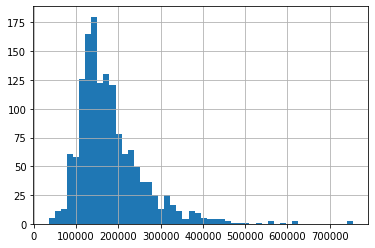

In [6]:
train['SalePrice'].hist(bins=50)

In [7]:
train['SalePrice'] = np.log(train['SalePrice'])

<AxesSubplot:title={'center':'SalePrice'}, xlabel='OverallQual'>

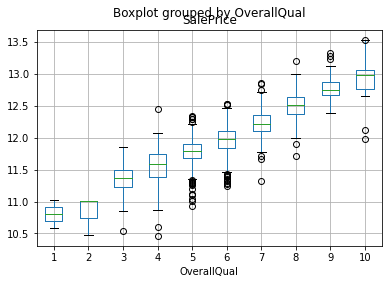

In [8]:
train.boxplot(by='OverallQual', column='SalePrice')

<AxesSubplot:>

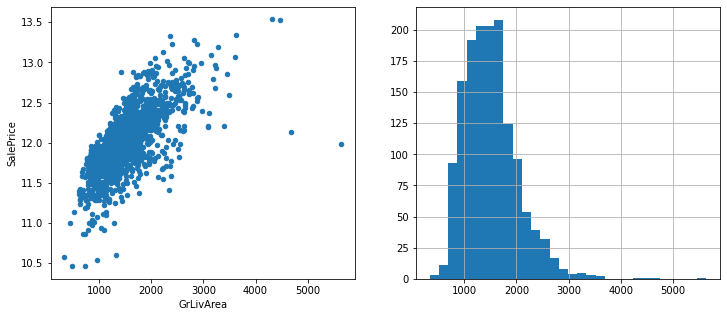

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train.plot.scatter(x='GrLivArea', y='SalePrice', ax=axes[0])
train['GrLivArea'].hist(bins=30, ax=axes[1])

<AxesSubplot:>

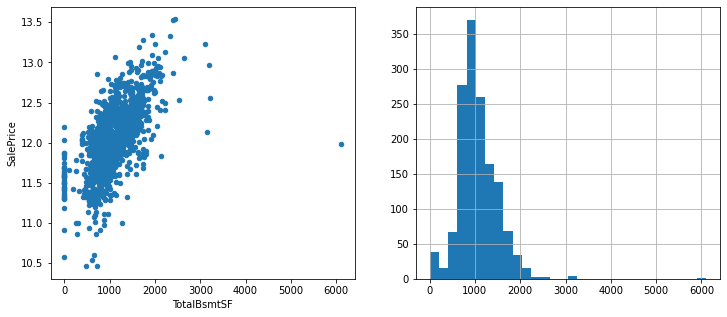

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ax=axes[0])
train['TotalBsmtSF'].hist(bins=30, ax=axes[1])

In [11]:
null_percent = train.isna().sum() / train.shape[0]
null_percent.loc[null_percent > 0.2]

Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

<AxesSubplot:>

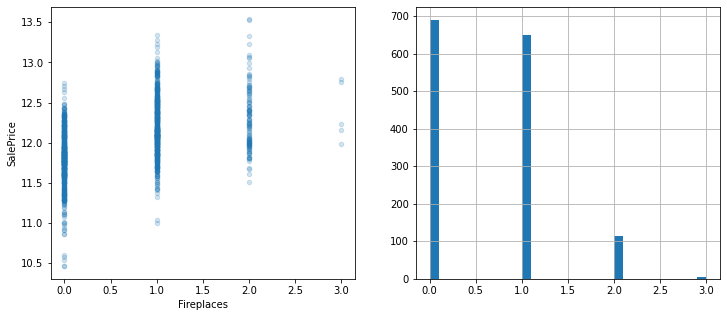

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train.plot.scatter(x='Fireplaces', y='SalePrice', alpha=0.2, ax=axes[0])
train['Fireplaces'].hist(bins=30, ax=axes[1])

In [13]:
drop_columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(columns=drop_columns, inplace=True);

In [14]:
num_nulls = train.select_dtypes(include=np.number).isna().sum()
num_nulls.loc[num_nulls > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

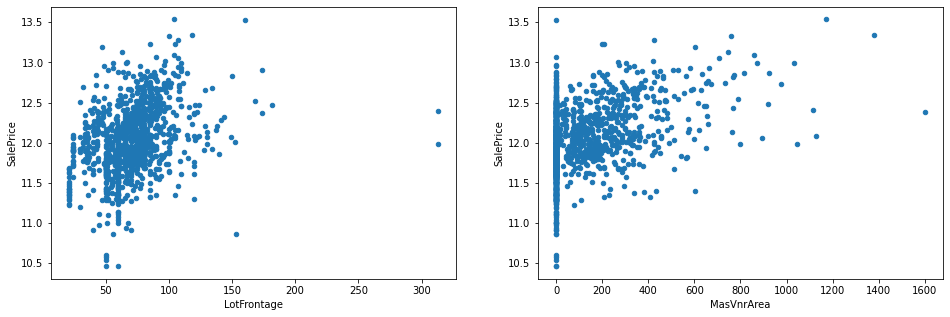

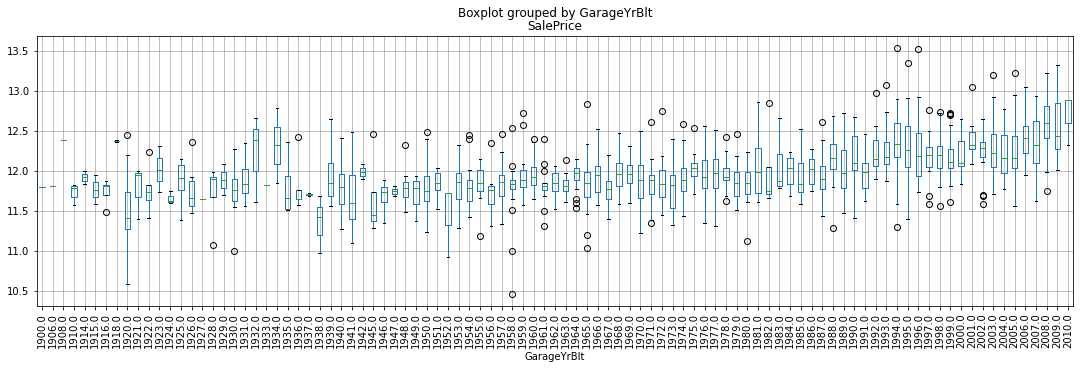

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
train.plot.scatter(x='LotFrontage', y='SalePrice', ax=axs[0])
train.plot.scatter(x='MasVnrArea', y='SalePrice', ax=axs[1])
train.boxplot(by='GarageYrBlt', column='SalePrice', figsize=(18,5))
plt.xticks(rotation=90);

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
column_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), OneHotEncoder(handle_unknown='ignore'))

col_transform = make_column_transformer(
    (num_pipe, make_column_selector(dtype_exclude='object')),
    (column_pipe, make_column_selector(dtype_include='object'))
)

In [17]:
X_raw = train.drop(columns=['SalePrice'])
X = col_transform.fit_transform(X_raw)
y = train['SalePrice']

In [18]:
test = load_data('test.csv')
X_test = test.drop(columns=drop_columns)

In [19]:
X_test_prep = col_transform.transform(X_test)

In [20]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import (GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor,
                              VotingRegressor, StackingRegressor)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform
from xgboost.sklearn import XGBRegressor
from learning_curve import plot_learning_curve

None


In [21]:
def rmse(y_pred, y_true):
    return mean_squared_error(y_pred, y_true, squared=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [22]:
def param_curve(model, param, start=1, end=100, step=1, verbose=True):
    x_ax = []
    scores = []
    val_scores = []

    for n in np.arange(start, end, step):
        model.set_params(**{param: n})
        model.fit(X, y)
        x_ax.append(n)
        scores.append(model.score(X, y))
        val_scores.append(cross_val_score(model, X, y).mean())
        if verbose:
            print(f'n = {n}\tscore = {scores[-1]}\tval score = {val_scores[-1]}')
    
    plt.plot(x_ax, scores, label='Train scores')
    plt.plot(x_ax, val_scores, label='Validation scores')
    plt.xlabel(param)
    plt.ylabel('Cost')
    plt.show()

In [23]:
def submit(model):
    predictions = np.exp(model.predict(X_test_prep))
    submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
    print(submission)
    submission.to_csv('submission.csv', index=False)

In [24]:
ridge = RidgeCV(alphas=[0.1, 0.3, 1, 3, 10, 30])
ridge.fit(X, y)

print(f'score = {ridge.score(X, y)}\tval = {cross_val_score(ridge, X, y).mean()}\
\talpha = {ridge.alpha_}')

score = 0.9215418889309325	val = 0.8746255816404711	alpha = 10.0


In [25]:
lasso = LassoCV(n_jobs=-1)
lasso.fit(X, y)

print(f'score = {lasso.score(X, y)}\tval = {cross_val_score(lasso, X, y).mean()}\
\talpha = {lasso.alpha_}')

score = 0.9249142671650075	val = 0.875062096551312	alpha = 0.0005702430410930377


In [26]:
lin_svr = LinearSVR(max_iter=15000, C=0.2)
lin_svr.fit(X, y)

print(f'score = {lin_svr.score(X, y)}\tval = {cross_val_score(lin_svr, X, y).mean()}')

score = 0.9051470453772703	val = 0.8541042701926035


In [27]:
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.001)
svr_rbf.fit(X, y)

print(f'score = {svr_rbf.score(X, y)}\tval = {cross_val_score(svr_rbf, X, y).mean()}')

score = 0.9445044833003081	val = 0.9042945295520829


In [28]:
grad_boost = GradientBoostingRegressor(n_estimators=80, max_depth=5, max_features=20, min_samples_leaf=45)
grad_boost.fit(X, y)

print(f'score = {grad_boost.score(X, y)}\t\
val = {cross_val_score(grad_boost, X, y).mean()}')

score = 0.925187331528424	val = 0.8813071922057458


In [29]:
voting = VotingRegressor([
    ('lasso', lasso),
    ('svr_rbf', svr_rbf),
    ('grad_boost', grad_boost)
], n_jobs=-1, verbose=True)
voting.fit(X, y)

print(f'score = {voting.score(X, y)}\tval = {cross_val_score(voting, X, y).mean()}')

score = 0.9396690877135774	val = 0.9029691747741119


In [30]:
stack = StackingRegressor(estimators=[
        ('lin_svr', lin_svr),
        ('lasso', lasso),
        ('svr_rbf', svr_rbf),
        ('grad_boost', grad_boost),
        ('voting', voting)
    ],
    final_estimator=RandomForestRegressor(max_depth=None, min_samples_leaf=10,
                      n_estimators=50, n_jobs=-1),
    n_jobs=-1, verbose=3)
stack.fit(X, y)

print(f'score = {stack.score(X, y)}\tval = {cross_val_score(stack, X, y).mean()}')

score = 0.9388848187694052	val = 0.9054261503431693
